# Demo - White Box Attack (Imagenet)

In [95]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter('runs/white_box_attack_image_net')

In [96]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.1+cu102
Torchvision 0.10.1+cu102
Torchattacks 3.1.0
Numpy 1.21.2


In [97]:
USE_CUDA = torch.cuda.is_available() 
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu') 
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


## 1. Load Data

In [98]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [99]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    
# Using normalization for Inception v3.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],                     
#                          std=[0.229, 0.224, 0.225])
    
# However, DO NOT USE normalization transforms here.
# Torchattacks only supports images with a range between 0 and 1.
# Thus, please refer to the model construction section.
    
])


In [100]:
imagnet_data = image_folder_custom_label(root='./data/oneImage', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


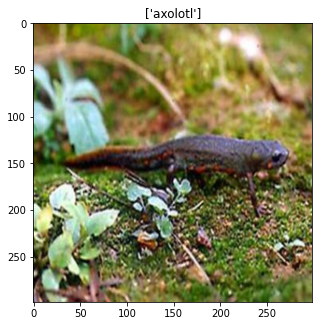

In [101]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True, nrow = 10), [imagnet_data.classes[i] for i in labels])

In [102]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
# (아래 `plot_classes_preds` 함수에서 사용)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

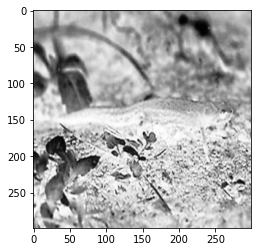

In [103]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(data_loader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

## 2. Load Inception v3

In [104]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [105]:
import ipywidgets
# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.

norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.wide_resnet50_2(pretrained=True)
    # models.resnet18(pretrained=True)
).cuda()

# class MyModel(nn.Module):
#     def __init__(self, mean, std):
#         super(MyModel, self).__init__()
#         self.register_buffer('mean', torch.Tensor(mean))
#         self.register_buffer('std', torch.Tensor(std))
        
#         self.layer1 = nn.Sequential(
#             norm_layer,
#             models.wide_resnet50_2(pretrained=True)
#         )
#     def forward(self, input):
#         # Broadcasting
#         mean = self.mean.reshape(1, 3, 1, 1)
#         std = self.std.reshape(1, 3, 1, 1)
#         return (input - mean) / std
        

model = model.eval()
# model = MyModel(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).eval()
Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).cuda()

Normalize()

In [106]:
# writer.add_graph(model, images)
# writer.close()

In [107]:
# from torchviz import make_dot
# from torch.autograd import Variable

# # Variable을 통하여 Input 생성
# x = Variable(torch.randn(1, 8)) 

# # 앞에서 생성한 model에 Input을 x로 입력한 뒤 (model(x))  graph.png 로 이미지를 출력합니다.
# make_dot(model(x), params=dict(model.named_parameters())).render("graph", format="png")

## 3. Adversarial Attack

In [108]:
from torchattacks import *

In [109]:
atks = [
    FGSM(model, eps=8/255),
    #BIM(model, eps=8/255, alpha=2/255, steps=100),
    #RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    #CW(model, c=1, lr=0.01, steps=100, kappa=0),
    # PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    #PGDL2(model, eps=1, alpha=0.2, steps=100),
    #EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    # FFGSM(model, eps=8/255, alpha=10/255),
    # TPGD(model, eps=8/255, alpha=2/255, steps=100),
    # MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    # VANILA(model),
    # GN(model, sigma=0.1),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    # APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    # Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    #AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    # OnePixel(model, pixels=5, inf_batch=50),
    # DeepFool(model, steps=100),
    # DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)
torch.Size([1, 3, 299, 299])
torch.Size([1, 1000])
torch.Size([1, 1000])
tensor([[26, 57, 32, 25, 52]], device='cuda:0')
torch.Size([1])
tensor([29], device='cuda:0')
정답:['axolotl']
예측:['common_newt']
top5:

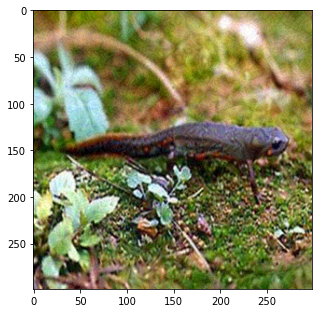

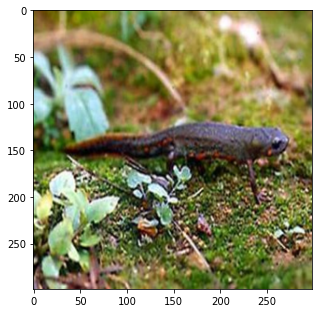

Total elapsed time (sec): 0.28
Robust accuracy: 0.00 %
Top5 Accuracy


In [110]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    top5_correct = 0
    total = 0
    
    for images, labels in data_loader: # batch로 나눠서 돌리는듯.
        # images : torch.Size([1,3,299,299])
        # labels: torch.Size([10]),[7, 5, 388, 1, ...] -> cock, electric_ray, giant_panda...
        
        print(images.shape)
        start = time.time()
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images) # outputs: torch.Size([batch_size, 1000]), adversarial image를 모델에 넣은 결과, outputs.data:[batch_size, 1000]
        print(outputs.shape)
        print(outputs.data.shape)
        _, pre = torch.max(outputs.data, 1) # 1000 classes중 가장 큰 VALUE 1 남음, value, index 나온다. batch_size>1이면 batch_size크기의 array로 나온다.
        _, top_5 = torch.topk(outputs.data, 5)

        print(top_5)
        print(labels.shape)
        total += len(images)
        correct += (pre == labels).sum()

        for i in range(top_5.shape[0]):
            print(labels)
            if labels in top_5[i]:
                top5_correct += 1

        for i in range(len(pre)):
            if pre[i] == labels[i]:
                print("같다!!!!!!!!!!!!")
                print(labels[i])
        print("정답:", end="")
        print([imagnet_data.classes[i] for i in labels])
        print("예측:", end="")
        print([imagnet_data.classes[j] for j in pre])
        print("top5:", end='')
        # print([imagnet_data.classes[k] for k in top_5])
        imshow(img=torchvision.utils.make_grid(adv_images.cpu().data, normalize=True, nrow = 10), title=None)
        imshow(img=torchvision.utils.make_grid(images, normalize=True, nrow = 10), title=None)
    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

    print("Top5 Accuracy")
    

## 4. Report Generating

In [111]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    print(tensor.shape)
    # if np.ndim(tensor)>3:
    #     assert tensor.shape[0] == 1
    #     tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [116]:
import numpy as np 
from PIL import Image 

array = np.random.randint(255, size=(400, 400),dtype=np.uint8)
image = Image.fromarray(array)
image.show() 

Unable to init server: Could not connect: Connection refused

(eog:5945): Gtk-WARNING **: 12:51:29.623: cannot open display: 


In [113]:
from fpdf import FPDF
from torchvision.transforms.functional import to_pil_image
from PIL.Image import Image
import PIL

class PDF(FPDF):
    def header(self):
        # hash문제 때문에 추가 
        #temp = to_pil_image(adv_images.cpu().data[0]).tobytes()
        #my_img = Image().frombytes(data=temp)

        # Rendering logo:
        #self.image(my_img, 10, 8, 33)
        # Setting font: helvetica bold 15
        self.set_font("Times", "B", 20)
        # Moving cursor to the right:
        self.cell(80)
        self.cell(30, 10, "Benchmark Result", 0, 0, "C")
        # Performing a line tbreak:
        self.ln(20)

    def footer(self):
        # Position cursor at 1.5 cm from bottom:
        self.set_y(-15)
        # Setting font: helvetica italic 8
        self.set_font("helvetica", "I", 8)
        # Printing page number:
        self.cell(0, 10, f"Page {self.page_no()}/{{nb}}", 0, 0, "C")


# Instantiation of inherited class
pdf = PDF()
pdf.set_display_mode(zoom='fullwidth',layout='two')
pdf.alias_nb_pages() # 페이지 수에 대한 alias ?
pdf.add_page() 


# 1. Mapped Network
pdf.set_font("Times", "B", size=12)
pdf.cell(0, 10, f"Mapped Network", 0, 1)
pdf.set_font("Helvetica", "I", 12)
pdf.cell(0, 10, f"<This function is still working in process.>", 0, 1)

pdf.cell(w=0, h=10, txt=f"Top-5 Accuracy against attacks", border=0, ln=1) # ln: 커서 포지션을 다음줄로 바꾼다. 

## table 추가

# Effective page width, or just epw
epw = pdf.w - 2*pdf.l_margin
 
# Set column width to 1/4 of effective page width to distribute content 
# evenly across table and page
col_width = epw/8
 
# Since we do not need to draw lines anymore, there is no need to separate
# headers from data matrix.
 
data = [['Top-5 Accuracy','Best Case','Average Case','Worst Case'],
['CW','40%','33%','20%'],
['JSMA','60%','60%','64%'],
['PGD','60%','60%','64%'],]

# pdf.cell(epw, 0.0, 'With more padding', align='C')
pdf.set_font('Times','',10.0) 
pdf.ln(0.5)
 
# Text height is the same as current font size
th = pdf.font_size
 
# Here we add more padding by passing 2*th as height
for row in data:
    for datum in row:
        # Enter data in colums
        pdf.cell(col_width, 2*th, str(datum), border=1)
 
    pdf.ln(2*th)

# 3. 성공한 adversarial example들
pdf.set_font("Times", "B", size=12)
pdf.cell(0, 10, f"Succeeded Adversarial examples", 0, 1)


# 4. attack result graph
pdf.set_font("Times", "B", size=12)
pdf.cell(0, 10, f"Attack Results with graph", 0, 1)

# 5. Advise
pdf.set_font("Times", "B", size=12)
pdf.cell(0, 10, f"Advise for your model robustness", 0, 1)

pdf.output("tuto2.pdf")

Unable to init server: Could not connect: Connection refused

(eog:5324): Gtk-WARNING **: 12:33:57.712: cannot open display: 


''